# Sistema de recomendação de animes

Este notebook tem como objetivo a construção de um sistema de recomendação de animes a partir de dois datasets: `animes.csv`, que descreve características de diversos animes e `rating.csv`, que descreve as avaliações que os usuários deram para eles. 

Neste projeto optou-se por usar a técnica de filtros colaborativos baseados no comportamento dos usuários, pela simplicidade e eficiência da técnica. Essa técnica pode ser interpretada como uma recomendação de animes baseada no que outros usuários semelhantes a você assistiram e gostaram.

Este documento é dividido da seguinte forma:

1. Coleta e tratamento dos dados
2. Análise exploratória
3. Preparação dos dados
4. Implementação e avaliação dos resultados
5. Exemplos de recomendações
6. Conclusões
7. Referências

## Coleta e tratamento dos dados

Os dados utilizados no projeto são provenientes do dataset [Anime Recommendations Database](https://www.kaggle.com/CooperUnion/anime-recommendations-database) do Kaggle. Ele é composto por dados referentes a preferência de usuários (73516 usuários) e dados descritivos de animes (12294 animes). 

In [38]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
import os, random
from surprise import KNNBasic, Dataset, Reader, accuracy, GridSearch

animes_df = pd.read_csv('data/anime.csv', na_values=["nan", "Unknown", "NA", ""])
ratings_df = pd.read_csv ('data/rating.csv', na_values=["nan", "Unknown", "NA", "", -1])
animes_df.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10.0,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148.0,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110.0,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1.0,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13.0,9.11,81109


O dataset de animes é composto pelas seguintes colunas:
* anime_id: contém o identificador único de cada anime
* name: nome do anime
* genre: lista de categorias a qual o anime pertence
* type: tipo do título
* episodios: quantidade de episódios do anime
* rating: média das reviews do anime (escala de 1-10)
* members: número de usuários que está no "grupo" desse anime

In [39]:
ratings_df.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


O dataset de ratings é composto pelas seguintes colunas:
* user_id: contém o identificador único de cada usuário
* anime_id: contém o identificador único de cada anime
* rating: contém o valor de rating atribuído por um usuário a um anime. "NaN" significa que o usuário assistiu ao anime mas não deu rating ao mesmo

## Análise exploratória

### 1. Animes

Esta seção explora como se comportam as variáveis presentes no dataset `anime.csv`. Em especial avalia-se quais os tipos de anime mais aparecem, como os ratings estão distribuídos e qual a relação existente entre as variáveis numéricas.

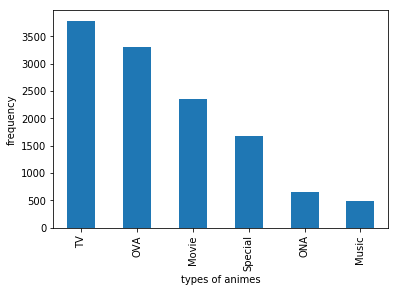

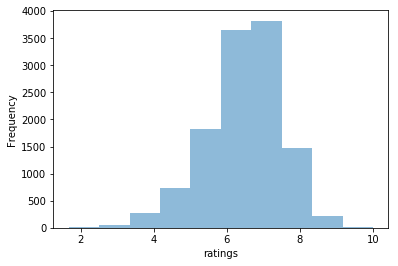

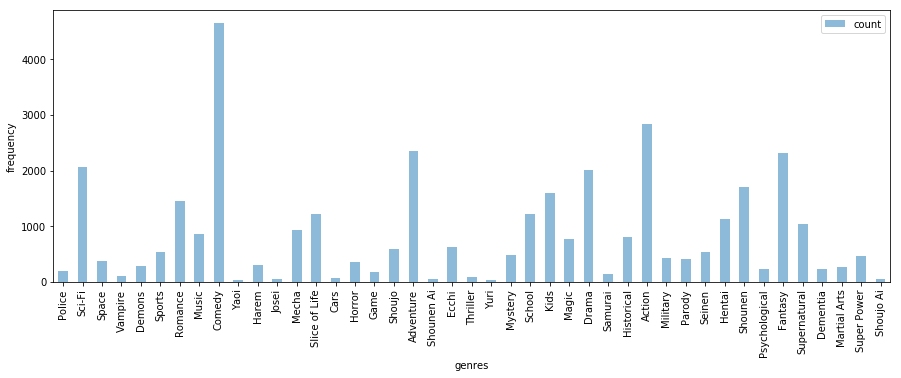

In [46]:
genres_list = []
genres_col_list = animes_df.genre.tolist()

for item in genres_col_list:
  if isinstance(item, basestring):
    l = item.split(",")
    # remove white spaces at the end and beginnin of string
    l = map(str.strip, l)
    genres_list.extend(l)

c = Counter(genres_list)
genres_df = pd.DataFrame.from_dict(c, orient='index').rename(columns={'įndex': 'genre', 0:'count'})

plt.figure()
ax = animes_df.type.value_counts().plot(kind='bar')
ax.set_ylabel("frequency")
ax.set_xlabel("types of animes")

plt.figure()
ax = animes_df.rating.plot.hist(alpha=0.5)
ax.set_xlabel("ratings")

plt.figure()
ax = genres_df.plot.bar(alpha=0.5, figsize=(15,5))
ax.set_xlabel("genres")
ax.set_ylabel("frequency")
plt.show()

É possível perceber que a maior parte dos animes foi produzida para TV ou no formato OVA. Além disso, os ratings estão distribuídos em um formato que lembra uma curva normal, com uma concentração de valores entre 6 e 8. Existem 43 tipos diferentes de gêneros e, dentre eles, os que mais possuem animes são: Comédia, Ação, Aventura e Fantasia.

O gráfico de barras abaixo mostra que os animes do tipo TV possuem muito mais membros em seus grupos na média. 

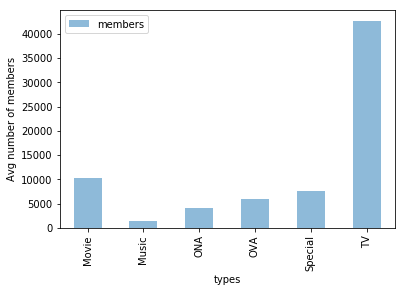

In [7]:
type_members_df = animes_df[['type', 'members']]
type_members_grouped_df = type_members_df.groupby('type').mean()

plt.figure()
ax = type_members_grouped_df.plot.bar(alpha=0.5)
ax.set_xlabel("types")
ax.set_ylabel("Avg number of members")
plt.show()

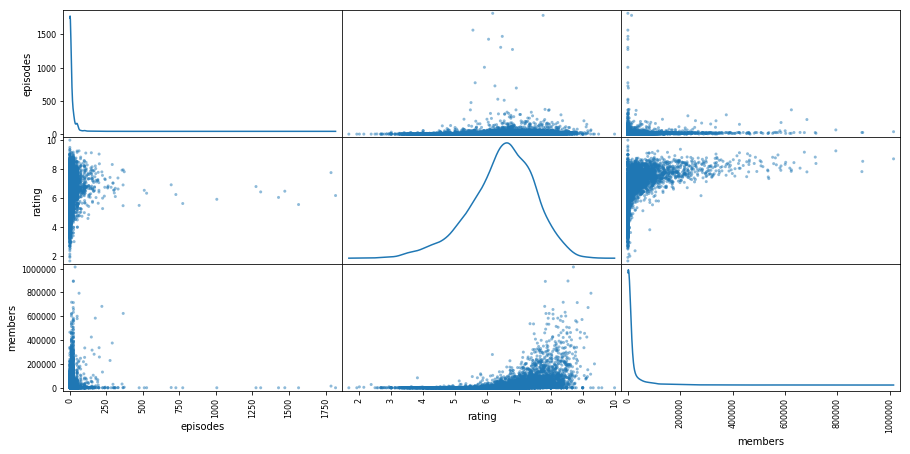

In [57]:
plt.figure()
pd.plotting.scatter_matrix(animes_df[['episodes', 'rating', 'members']], alpha=0.5, figsize=(15, 7), diagonal='kde')
plt.show()

A partit da _scatter matrix_ acima, perceb-se que:

* Os animes com maiores quantidades de episódios tem rating mediano (entre 5 e 7). 
* Existe uma tendência de crescimento do rating de acordo com o crescimento da quantidade de membros no grupo
* Os animes com maior quantidade de episódios parecem tender a ter menos membros em seu grupo

### 2. Ratings

Cada linha desse dataset representa uma vez em que o usuário X assistiu ao anime Y. Analisando os animes únicos que foram assistidos, percebe-se que o número difere da quantidade de animes disponíveis no dataset do item 1. Ou seja, existem animes que não foram vistos. Abaixo foram listados 5 deles. 

In [13]:
animes_watched = ratings_df.anime_id.unique()
qtd_animes_watched = len(ratings_df.anime_id.unique())
qtd_animes = animes_df.shape[0]

print("Total number of animes: {}".format(qtd_animes))
print("Number of watched animes: {}".format(qtd_animes_watched))

animes_df[~animes_df.anime_id.isin(animes_watched)].head()

Total number of animes: 12294
Number of watched animes: 11200


,anime_id,name,genre,type,episodes,rating,members
31,32983,Natsume Yuujinchou Go,"Drama, Fantasy, Shoujo, Slice of Life, Superna...",TV,13.0,8.76,38865
62,32995,Yuri!!! on Ice,"Comedy, Sports",TV,12.0,8.61,103178
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,NaN,8.58,504862
76,31933,JoJo no Kimyou na Bouken: Diamond wa Kudakenai,"Action, Adventure, Comedy, Drama, Shounen, Sup...",TV,39.0,8.57,74074
140,10937,Mobile Suit Gundam: The Origin,"Action, Mecha, Military, Sci-Fi, Shounen, Space",OVA,6.0,8.42,15420


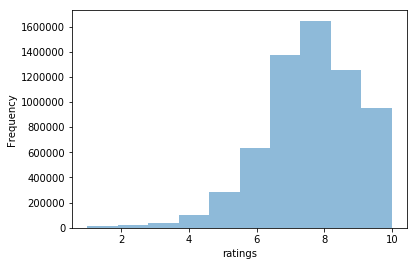

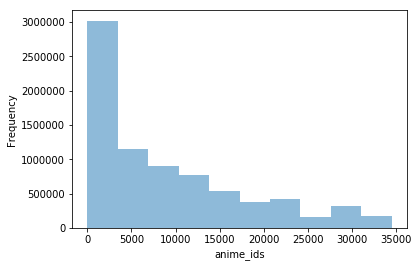

In [9]:
plt.figure()
ax = ratings_df.rating.plot.hist(alpha=0.5)
ax.set_xlabel("ratings")

plt.figure()
ax = ratings_df.anime_id.plot.hist(alpha=0.5)
ax.set_xlabel("anime_ids")

plt.show()

Em relação ao comportamento dos ratings, percebe-se que existe uma concentração das notas entre 7 e 8, intervalo semelhante ao observado no dataset de animes. 

Já em relação aos animes assistidos, observa-se que aqueles com menor ID são bem mais assistidos do que aqueles com ID maior. Se considerarmos que ID maior representa um anime mais novo ou que foi cadastrado recentemente, esse dado faz sentido, pois os usuários não teriam tido tempo suficiente para assistí-lo. 

## Preparação dos dados

### Filtro colaborativo

Este projeto utilizará a biblioteca [Surprise](http://surprise.readthedocs.io) do Python para fazer as recomendações. Ela funciona da seguinte forma: dado um arquivo contendo toda a listagem de usuários, animes e rating, a biblioteca lê esse arquivo, cria a matrix User-Anime-Rating internamente e aplica o método de filtro colaborativo desejado. 

O uso dessa biblioteca otimiza o tempo de codificação, análise e recomendação deste projeto. O arquivo **script.py** presente neste projeto contém um exemplo de implementação manual de filtros colaborativos baseados em vizinhança.

Por razões computacionais, reduziu-se o espaço amostral de usuários para aqueles que possuem ID menor ou igual a 5k. Além disso, removeu-se todas as linhas com `NaN`. Para considerar todo o espaço amostral seria necessário usar plataformas de processamento de dados em larga escala, como o Spark.  

Nesta seção faremos o tratamento dos dados de rating e exportaremos um dataset no formato adequado para ser usado no Surprise.

In [47]:
# join datasets in order to get anime_name
dataset = ratings_df.merge(animes_df, on='anime_id', suffixes=['_user', ''])

dataset = dataset[['user_id', 'anime_id', 'rating_user']]

# limit number of users evaluated for computing reasons
dataset_sub = dataset[dataset.user_id <= 5000]

# remove entries in which user did not rate anime
dataset_sub = dataset_sub[dataset_sub.rating_user.notnull()]

dataset_sub.to_csv("data/surprise_data.csv", index=False, header=False)
print("Dataset exported successfully")

Dataset exported successfully


## Implementação e Avaliação dos resultados

O código abaixo mostra a implementação do modelo de recomendação utilizando um algoritmo KNN Básico, no qual podemos configurar quantos usuários semelhantes ao usuário analisado serão considerados para elaborar a recomendação. Foi utilizada a classe GridSearch (semelhante a classe GridSearchCV do scikit-learn) para analisar os melhores parâmetros para o algoritmo. 

Como métrica de avaliação de desempenho, optou-se pela RMSE, que é bastante utilizada para análise de sistemas de recomendação. 

In [48]:
# path to dataset file
file_path = os.path.expanduser('data/surprise_data.csv')
num_of_users = len(dataset_sub.user_id.unique())

# As we're loading a custom dataset, we need to define a reader. In the
# movielens-100k dataset, each line has the following format:
# 'user item rating timestamp', separated by '\t' characters.
reader = Reader(line_format='user item rating', sep=',')

data = Dataset.load_from_file(file_path, reader=reader)

raw_ratings = data.raw_ratings

# shuffle data
random.seed(10)
random.shuffle(raw_ratings)

# Train = 75% of the data, Test = 25% of the data
threshold = int(.75 * len(raw_ratings))
train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

# prepare train data
data.raw_ratings = train_raw_ratings  
data.split(n_folds=2)

# Select the best estimator with grid search.
param_grid = {'sim_options': [{'name': 'cosine', 'user_based': True }], 'k': [10, 30, num_of_users]}
grid_search = GridSearch(KNNBasic, param_grid, measures=['RMSE'], verbose=1)
grid_search.evaluate(data)

estimator = grid_search.best_estimator['RMSE']

# create trainingset
trainset = data.build_full_trainset()
# train the model
estimator.train(trainset)

# Compute unbiased accuracy on Test
testset = data.construct_testset(test_raw_ratings) 
predictions = estimator.test(testset)
print('Unbiased accuracy on B {}'.format(accuracy.rmse(predictions)))


print("The best params are: {}".format(grid_search.best_params))
print("The best estimator has error: {}".format(grid_search.best_score))

------------
Parameters combination 1 of 3
params:  {'sim_options': {'name': 'cosine', 'user_based': True}, 'k': 10}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 3.2383
------------
------------
Parameters combination 2 of 3
params:  {'sim_options': {'name': 'cosine', 'user_based': True}, 'k': 30}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 3.2382
------------
------------
Parameters combination 3 of 3
params:  {'sim_options': {'name': 'cosine', 'user_based': True}, 'k': 4701}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 3.2382
------------
Computing the cosine similarity matrix...
Done computing si

A partir dos dados acima, é possível identificar que o melhor valor de **k** para o KNNBasic é 30. Isso significa que o sistema não precisa considerar o comportamento de todos o usuários para recomendar corretamente animes, fazendo com que o esforço computacional para calcular as recomendações seja menor. 

## Exemplos de recomendação

O melhor modelo criado na seção anterior será utilizado nesta para gerar recomendações para alguns usuários. As recomendações não foram organizadas por ordem de relevância. 

In [65]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=5)

# get some users
users_example = {key:value for key,value in top_n.items()[0:2]}
anime_recs = []
uids = []
# Print the recommended items for each user
for uid, user_ratings in users_example.items():
    items = [iid for (iid, _) in user_ratings]
    uids.append(uid)
    anime_recs.append(animes_df[animes_df.anime_id.isin(items)])

In [66]:
print("Recommendations for user {}".format(uids[0]))
anime_recs[0][['anime_id', 'name']]

Recommendations for user 2031


,anime_id,name
57,9989,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...
214,6,Trigun
217,11977,Mahou Shoujo Madoka★Magica Movie 1: Hajimari n...
358,47,Akira
644,1818,Claymore


In [67]:
print("Recommendations for user {}".format(uids[1]))
anime_recs[1][['anime_id', 'name']]

Recommendations for user 1867


,anime_id,name
36,11741,Fate/Zero 2nd Season
643,9919,Ao no Exorcist
724,15451,High School DxD New
937,20785,Mahouka Koukou no Rettousei
1130,22729,Aldnoah.Zero


## Conclusões

Neste projeto foi implementado um sistema de recomendação de animes baseado no dataset do Kaggle. Utilizou-se a biblioteca Pandas para exploração, tratamento dos dados e preparação dos dados. Para implementação do modelo foi usada a biblioteca Surprise, pois ela é especializada em sistemas de recomendação, contendo métodos para avaliação, cross validation e gridsearch nos modelos. Ela otimizou o tempo de criação deste relatório. 

Foram também apresentados exemplos de recomendação baseadas nos usuários. Foram geradas recomendações para os usuários com IDs=[2031, 1867]. 

Para trabalhos futuros, vislumbram-se as seguintes possibilidades:

* **Combinar o resultado do filtro colaborativo com recomendações baseadas em conteúdo**: um dos problemas que o filtro colaborativo tem é o _cold start_, pois o sistema não sabe o que recomendar para um novo usuário, uma vez que ele não tem histórico prévio. As recomendações baseadas em conteúdo supririam essa demanda
* **Testar outros algoritmos**: os filtros colaborativos podem ser divididos em _neighborhood-based approach_ e _model based approach_. Neste projeto utilizamos a primeira das abordagens. Em trabalhos futuros podem ser testados diferentes modelos, tal como o SVD. 


## Referências

[1] WIT, Joost de. Evaluating Recommender Systems: An evaluation framework to predict user satisfaction for recom- mender systems in an electronic programme guide context. 2008. Disponível em: <http://essay.utwente.nl/59711/1/MA_thesis_J_de_Wit.pdf>

[2]  SHANI, Guy; GUNAWARDANA, Asela. Evaluating Recommender Systems. TechReport. Disponível em: <https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/EvaluationMetrics.TR_.pdf>

[3] AIN, Aarshay. Quick Guide to Build a Recommendation Engine in Python. 2016. Blog Post. Disponível em: <https://www.analyticsvidhya.com/blog/2016/06/quick-guide-build-recommendation-engine-python/>

[4] KUMAR , Suresh. Building Recommendation Engines. 1. ed. [S.l.]: Packt, 2016. 372 p.

[5] JOHANNSDOTTIR, Agnes. Implementing your own recommender systems in Python. Disponível em: <https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html>. Acesso em: 11 set. 2017

[6] ROSENTHAL, Ethan. Intro to Recommender Systems: Collaborative Filtering. Disponível em: <http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/>. Acesso em: 11 set. 2017